<a href="https://colab.research.google.com/github/Leviathan-Levi/NeuroAI/blob/Project/Template_MLP_digit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# @title Importing dependencies

from IPython.display import Image, SVG, display
import os
from pathlib import Path

import random
from tqdm import tqdm
import warnings
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import torchvision
import contextlib
import io

# @title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")

# Download MNIST dataset
download the MNIST handwritten digits dataset

It is provided as a training dataset (60,000 examples) and a test dataset (10,000 examples). We can split the training dataset to obtain a training (e.g., 80%) and a validation set (e.g., 20%). In addition, since the dataset is quite large, we also suggest keeping only half of each subset, as this will make training the models faster.

In [3]:
# @markdown `download_mnist()`: Function to download MNIST.

def download_mnist(train_prop=0.8, keep_prop=0.5):

  valid_prop = 1 - train_prop

  discard_prop = 1 - keep_prop

  transform = torchvision.transforms.Compose(
      [torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize((0.1307,), (0.3081,))]
      )


  with contextlib.redirect_stdout(io.StringIO()): #to suppress output

      full_train_set = torchvision.datasets.MNIST(
          root="./data/", train=True, download=True, transform=transform
          )
      full_test_set = torchvision.datasets.MNIST(
          root="./data/", train=False, download=True, transform=transform
          )

  train_set, valid_set, _ = torch.utils.data.random_split(
      full_train_set,
      [train_prop * keep_prop, valid_prop * keep_prop, discard_prop]
      )
  test_set, _ = torch.utils.data.random_split(
      full_test_set,
      [keep_prop, discard_prop]
      )

  print("Number of examples retained:")
  print(f"  {len(train_set)} (training)")
  print(f"  {len(valid_set)} (validation)")
  print(f"  {len(test_set)} (test)")

  return train_set, valid_set, test_set

In [4]:
train_set, valid_set, test_set = download_mnist()

100%|██████████| 4542/4542 [00:00<00:00, 2494504.23it/s]

Number of examples retained:
  24001 (training)
  5999 (validation)
  5000 (test)


#Explore the dataset

In [5]:
#@markdown To get started exploring the dataset, here are a few plotting functions:

#@markdown `get_plotting_color()`: Returns a color for the specific dataset, e.g. "train" or model index.
def get_plotting_color(dataset="train", model_idx=None):
  if model_idx is not None:
    dataset = None

  if model_idx == 0 or dataset == "train":
    color = "#1F77B4" # blue
  elif model_idx == 1 or dataset == "valid":
    color = "#FF7F0E" # orange
  elif model_idx == 2 or dataset == "test":
    color = "#2CA02C" # green
  else:
    if model_idx is not None:
      raise NotImplementedError("Colors only implemented for up to 3 models.")
    else:
      raise NotImplementedError(
          f"{dataset} dataset not recognized. Expected 'train', 'valid' "
          "or 'test'."
          )

  return color


#@markdown `plot_examples(subset)`: Plot examples from the dataset organized by their predicted class
#@markdown (if a model is provided) or by their class label otherwise
def plot_examples(subset, num_examples_per_class=8, MLP=None, seed=None,
                  batch_size=32, num_classes=10, ax=None):
  """
  Function for visualizing example images from the dataset, organized by their
  predicted class, if a model is provided, or by their class, otherwise.

  Arguments:
  - subset (torch dataset or torch dataset subset): dataset from which to
    visualized images.
  - num_examples_per_class (int, optional): number of examples to visualize per
    class
  - MLP (MultiLayerPerceptron or None, optional): model to use to retrieve the
    predicted class for each image. If MLP is None, images will be organized by
    their class label. Otherwise, images will be organized by their predicted
    class.
  - seed (int or None, optional): Seed to use to randomly sample images to
    visualize.
  - batch_size (int, optional): If MLP is not None, number of images to
    retrieve predicted class for at one time.
  - num_classes (int, optional): Number of classes in the data.
  - ax (plt subplot, optional): Axis on which to plot images. If None, a new
    axis will be created.

  Returns:
  - ax (plt subplot): Axis on which images were plotted.
  """

  if MLP is None:
    xlabel = "Class"
  else:
    MLP.eval()
    xlabel = "Predicted class"

  if ax is None:
    fig_wid = min(8, num_classes * 0.6)
    fig_hei = min(8, num_examples_per_class * 0.6)
    _, ax = plt.subplots(figsize=(fig_wid, fig_hei))

  if seed is None:
    generator = None
  else:
    generator = torch.Generator()
    generator.manual_seed(seed)

  loader = torch.utils.data.DataLoader(
      subset, batch_size=batch_size, shuffle=True, generator=generator
      )

  plot_images = {i: list() for i in range(num_classes)}
  with torch.no_grad():
    for X, y in loader:
      if MLP is not None:
        y = MLP(X)
        y = torch.argmax(y, axis=1)

      done = True
      for i in range(num_classes):
        num_to_add = int(num_examples_per_class - len(plot_images[i]))
        if num_to_add:
          add_images = np.where(y == i)[0]
          if len(add_images):
            for add_i in add_images[: num_to_add]:
              plot_images[i].append(X[add_i, 0].numpy())
          if len(plot_images[i]) != num_examples_per_class:
            done = False

      if done:
        break

  hei, wid = X[0, 0].shape
  final_image = np.full((num_examples_per_class * hei, num_classes * wid), np.nan)
  for i, images in plot_images.items():
    if len(images):
      final_image[: len(images) * hei, i * wid: (i + 1) * wid] = np.vstack(images)

  ax.imshow(final_image, cmap="gray")

  ax.set_xlabel(xlabel)
  ax.set_xticks((np.arange(num_classes) + 0.5) * wid)
  ax.set_xticklabels([f"{int(i)}" for i in range(num_classes)])
  ax.set_yticks([])
  ax.set_title(f"Examples per {xlabel.lower()}")

  return ax

#@markdown `plot_class_distribution(train_set)`: Plots the distribution of classes in each set (train, validation, test).
def plot_class_distribution(train_set, valid_set=None, test_set=None,
                            num_classes=10, ax=None):
  """
  Function for plotting the number of examples per class in each subset.

 Arguments:
  - train_set (torch dataset or torch dataset subset): training dataset
  - valid_set (torch dataset or torch dataset subset, optional): validation
    dataset
  - test_set (torch dataset or torch dataset subset, optional): test
    dataset
  - num_classes (int, optional): Number of classes in the data.
  - ax (plt subplot, optional): Axis on which to plot images. If None, a new
    axis will be created.

  Returns:
  - ax (plt subplot): Axis on which images were plotted.
  """

  if ax is None:
    _, ax = plt.subplots(figsize=(6, 3))

  bins = np.arange(num_classes + 1) - 0.5

  for dataset_name, dataset in [
      ("train", train_set), ("valid", valid_set), ("test", test_set)
      ]:
    if dataset is None:
      continue

    if hasattr(dataset, "dataset"):
      targets = dataset.dataset.targets[dataset.indices]
    else:
      targets = dataset.targets

    outputs = ax.hist(
        targets,
        bins=bins,
        alpha=0.3,
        color=get_plotting_color(dataset_name),
        label=dataset_name,
        )

    per_class = len(targets) / num_classes
    ax.axhline(
        per_class,
        ls="dashed",
        color=get_plotting_color(dataset_name),
        alpha=0.8
        )

  ax.set_xticks(range(num_classes))
  ax.set_title("Counts per class")
  ax.set_xlabel("Class")
  ax.set_ylabel("Count")
  ax.legend(loc="center right")

  return ax

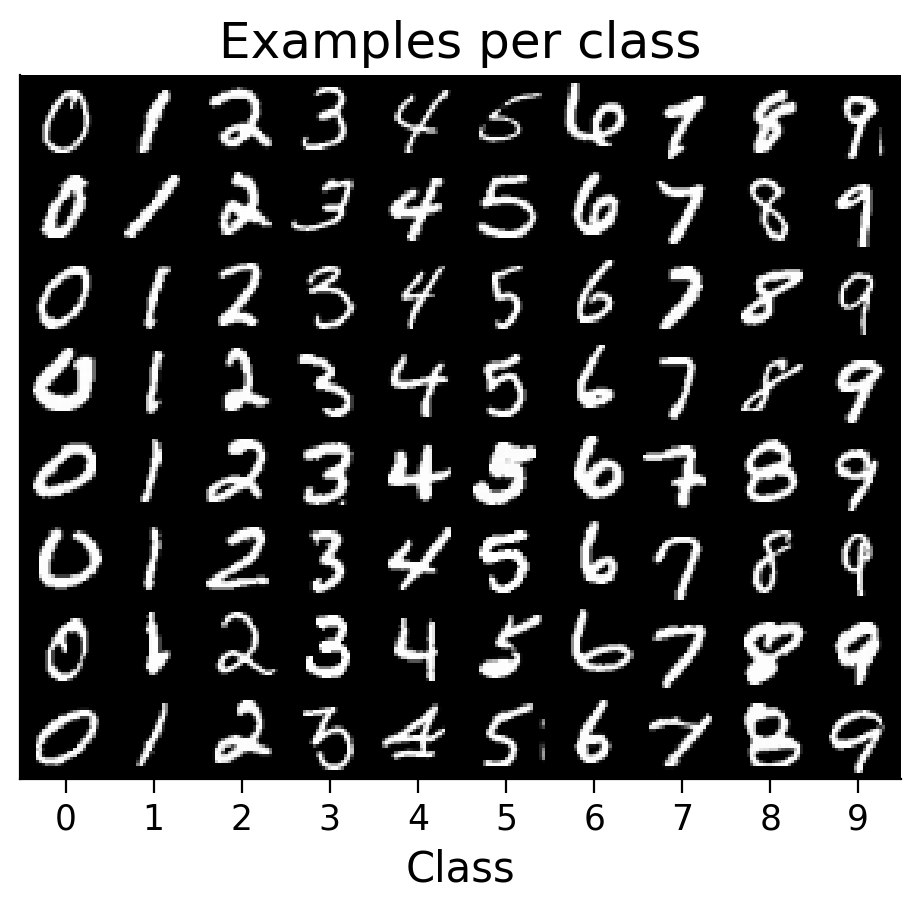

In [6]:
plot_examples(train_set);

#Defining a basic model

In [7]:
NUM_INPUTS = np.product(train_set.dataset.data[0].shape) # size of an MNIST image
NUM_OUTPUTS = 10 # number of MNIST classes

class MultiLayerPerceptron(torch.nn.Module):
  """
  Simple multilayer perceptron model class with one hidden layer.
  """

  def __init__(
      self,
      num_inputs=NUM_INPUTS,
      num_hidden=100,
      num_outputs=NUM_OUTPUTS,
      activation_type="sigmoid",
      bias=False,
      ):
    """
    Initializes a multilayer perceptron with a single hidden layer.

    Arguments:
    - num_inputs (int, optional): number of input units (i.e., image size)
    - num_hidden (int, optional): number of hidden units in the hidden layer
    - num_outputs (int, optional): number of output units (i.e., number of
      classes)
    - activation_type (str, optional): type of activation to use for the hidden
      layer ('sigmoid', 'tanh', 'relu' or 'linear')
    - bias (bool, optional): if True, each linear layer will have biases in
      addition to weights
    """


    super().__init__()

    self.num_inputs = num_inputs
    self.num_hidden = num_hidden
    self.num_outputs = num_outputs
    self.activation_type = activation_type
    self.bias = bias

    # default weights (and biases, if applicable) initialization is used
    # see https://github.com/pytorch/pytorch/blob/main/torch/nn/modules/linear.py
    self.lin1 = torch.nn.Linear(num_inputs, num_hidden, bias=bias)
    self.lin2 = torch.nn.Linear(num_hidden, num_outputs, bias=bias)

    self._store_initial_weights_biases()

    self._set_activation() # activation on the hidden layer
    self.softmax = torch.nn.Softmax(dim=1) # activation on the output layer


  def _store_initial_weights_biases(self):
    """
    Stores a copy of the network's initial weights and biases.
    """

    self.init_lin1_weight = self.lin1.weight.data.clone()
    self.init_lin2_weight = self.lin2.weight.data.clone()
    if self.bias:
      self.init_lin1_bias = self.lin1.bias.data.clone()
      self.init_lin2_bias = self.lin2.bias.data.clone()

  def _set_activation(self):
    """
    Sets the activation function used for the hidden layer.
    """

    if self.activation_type.lower() == "sigmoid":
      self.activation = torch.nn.Sigmoid() # maps to [0, 1]
    elif self.activation_type.lower() == "tanh":
      self.activation = torch.nn.Tanh() # maps to [-1, 1]
    elif self.activation_type.lower() == "relu":
      self.activation = torch.nn.ReLU() # maps to positive
    elif self.activation_type.lower() == "identity":
      self.activation = torch.nn.Identity() # maps to same
    else:
      raise NotImplementedError(
          f"{self.activation_type} activation type not recognized. Only "
          "'sigmoid', 'relu' and 'identity' have been implemented so far."
          )

  def forward(self, X, y=None):
    """
    Runs a forward pass through the network.

    Arguments:
    - X (torch.Tensor): Batch of input images.
    - y (torch.Tensor, optional): Batch of targets. This variable is not used
      here. However, it may be needed for other learning rules, to it is
      included as an argument here for compatibility.

    Returns:
    - y_pred (torch.Tensor): Predicted targets.
    """

    h = self.activation(self.lin1(X.reshape(-1, self.num_inputs)))
    y_pred = self.softmax(self.lin2(h))
    return y_pred

  def forward_backprop(self, X):
    """
    Identical to forward(). Should not be overwritten when creating new
    child classes to implement other learning rules, as this method is used
    to compare the gradients calculated with other learning rules to those
    calculated with backprop.
    """

    h = self.activation(self.lin1(X.reshape(-1, self.num_inputs)))
    y_pred = self.softmax(self.lin2(h))
    return y_pred


  def list_parameters(self):
    """
    Returns a list of model names for a gradient dictionary.

    Returns:
    - params_list (list): List of parameter names.
    """

    params_list = list()

    for layer_str in ["lin1", "lin2"]:
      params_list.append(f"{layer_str}_weight")
      if self.bias:
        params_list.append(f"{layer_str}_bias")

    return params_list


  def gather_gradient_dict(self):
    """
    Gathers a gradient dictionary for the model's parameters. Raises a
    runtime error if any parameters have no gradients.

    Returns:
    - gradient_dict (dict): A dictionary of gradients for each parameter.
    """

    params_list = self.list_parameters()

    gradient_dict = dict()
    for param_name in params_list:
      layer_str, param_str = param_name.split("_")
      layer = getattr(self, layer_str)
      grad = getattr(layer, param_str).grad
      if grad is None:
        raise RuntimeError("No gradient was computed")
      gradient_dict[param_name] = grad.detach().clone().numpy()

    return gradient_dict

#Initializing the model

In [8]:
# Model
NUM_HIDDEN = 100
ACTIVATION = "sigmoid" # output constrained between 0 and 1
BIAS = False

MLP = MultiLayerPerceptron(
    num_hidden=NUM_HIDDEN,
    activation_type=ACTIVATION,
    bias=BIAS,
    )


# Dataloaders
BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

#Defining and initializing an optimizer

In [9]:
class BasicOptimizer(torch.optim.Optimizer):
  """
  Simple optimizer class based on the SGD optimizer.
  """
  def __init__(self, params, lr=0.01, weight_decay=0):
    """
    Initializes a basic optimizer object.

    Arguments:
    - params (generator): Generator for torch model parameters.
    - lr (float, optional): Learning rate.
    - weight_decay (float, optional): Weight decay.
    """

    if lr < 0.0:
        raise ValueError(f"Invalid learning rate: {lr}")
    if weight_decay < 0.0:
        raise ValueError(f"Invalid weight_decay value: {weight_decay}")

    defaults = dict(
        lr=lr,
        weight_decay=weight_decay,
        )

    super().__init__(params, defaults)

  def step(self):
      """
      Performs a single optimization step.
      """

      for group in self.param_groups:
        for p in group["params"]:

          # only update parameters with gradients
          if p.grad is not None:

            # apply weight decay to gradient, if applicable
            if group["weight_decay"] != 0:
              p.grad = p.grad.add(p, alpha=group["weight_decay"])

            # apply gradient-based update
            p.data.add_(p.grad, alpha=-group["lr"])

In [10]:
LR = 0.01
backprop_optimizer = BasicOptimizer(MLP.parameters(), lr=LR)

#Training a basic model

In [11]:
#@markdown `train_model(MLP, train_loader, valid_loader, optimizer)`: Main function.
#@markdown Trains the model across epochs. Aggregates loss and accuracy statistics
#@markdown from the training and validation datasets into a results dictionary which is returned.
def train_model(MLP, train_loader, valid_loader, optimizer, num_epochs=5):
  """
  Train a model for several epochs.

  Arguments:
  - MLP (torch model): Model to train.
  - train_loader (torch dataloader): Dataloader to use to train the model.
  - valid_loader (torch dataloader): Dataloader to use to validate the model.
  - optimizer (torch optimizer): Optimizer to use to update the model.
  - num_epochs (int, optional): Number of epochs to train model.

  Returns:
  - results_dict (dict): Dictionary storing results across epochs on training
    and validation data.
  """

  results_dict = {
      "avg_train_losses": list(),
      "avg_valid_losses": list(),
      "avg_train_accuracies": list(),
      "avg_valid_accuracies": list(),
  }

  for e in tqdm(range(num_epochs)):
    no_train = True if e == 0 else False # to get a baseline
    latest_epoch_results_dict = train_epoch(
        MLP, train_loader, valid_loader, optimizer=optimizer, no_train=no_train
        )

    for key, result in latest_epoch_results_dict.items():
      if key in results_dict.keys() and isinstance(results_dict[key], list):
        results_dict[key].append(latest_epoch_results_dict[key])
      else:
        results_dict[key] = result # copy latest

  return results_dict


def train_epoch(MLP, train_loader, valid_loader, optimizer, no_train=False):
  """
  Train a model for one epoch.

  Arguments:
  - MLP (torch model): Model to train.
  - train_loader (torch dataloader): Dataloader to use to train the model.
  - valid_loader (torch dataloader): Dataloader to use to validate the model.
  - optimizer (torch optimizer): Optimizer to use to update the model.
  - no_train (bool, optional): If True, the model is not trained for the
    current epoch. Allows a baseline (chance) performance to be computed in the
    first epoch before training starts.

  Returns:
  - epoch_results_dict (dict): Dictionary storing epoch results on training
    and validation data.
  """

  criterion = torch.nn.NLLLoss()

  epoch_results_dict = dict()
  for dataset in ["train", "valid"]:
    for sub_str in ["correct_by_class", "seen_by_class"]:
      epoch_results_dict[f"{dataset}_{sub_str}"] = {
          i:0 for i in range(MLP.num_outputs)
          }

  MLP.train()
  train_losses, train_acc = list(), list()
  for X, y in train_loader:
    y_pred = MLP(X, y=y)
    loss = criterion(torch.log(y_pred), y)
    acc = (torch.argmax(y_pred.detach(), axis=1) == y).sum() / len(y)
    train_losses.append(loss.item() * len(y))
    train_acc.append(acc.item() * len(y))
    update_results_by_class_in_place(
        y, y_pred.detach(), epoch_results_dict, dataset="train",
        num_classes=MLP.num_outputs
        )
    optimizer.zero_grad()
    if not no_train:
      loss.backward()
      optimizer.step()

  num_items = len(train_loader.dataset)
  epoch_results_dict["avg_train_losses"] = np.sum(train_losses) / num_items
  epoch_results_dict["avg_train_accuracies"] = np.sum(train_acc) / num_items * 100

  MLP.eval()
  valid_losses, valid_acc = list(), list()
  with torch.no_grad():
    for X, y in valid_loader:
      y_pred = MLP(X)
      loss = criterion(torch.log(y_pred), y)
      acc = (torch.argmax(y_pred, axis=1) == y).sum() / len(y)
      valid_losses.append(loss.item() * len(y))
      valid_acc.append(acc.item() * len(y))
      update_results_by_class_in_place(
          y, y_pred.detach(), epoch_results_dict, dataset="valid"
          )

  num_items = len(valid_loader.dataset)
  epoch_results_dict["avg_valid_losses"] = np.sum(valid_losses) / num_items
  epoch_results_dict["avg_valid_accuracies"] = np.sum(valid_acc) / num_items * 100

  return epoch_results_dict


def update_results_by_class_in_place(y, y_pred, result_dict, dataset="train",
                                     num_classes=10):
  """
  Updates results dictionary in place during a training epoch by adding data
  needed to compute the accuracies for each class.

  Arguments:
  - y (torch Tensor): target labels
  - y_pred (torch Tensor): predicted targets
  - result_dict (dict): Dictionary storing epoch results on training
    and validation data.
  - dataset (str, optional): Dataset for which results are being added.
  - num_classes (int, optional): Number of classes.
  """

  correct_by_class = None
  seen_by_class = None

  y_pred = np.argmax(y_pred, axis=1)
  if len(y) != len(y_pred):
    raise RuntimeError("Number of predictions does not match number of targets.")

  for i in result_dict[f"{dataset}_seen_by_class"].keys():
    idxs = np.where(y == int(i))[0]
    result_dict[f"{dataset}_seen_by_class"][int(i)] += len(idxs)

    num_correct = int(sum(y[idxs] == y_pred[idxs]))
    result_dict[f"{dataset}_correct_by_class"][int(i)] += num_correct

In [12]:
NUM_EPOCHS = 20

MLP_results_dict = train_model(
    MLP,
    train_loader,
    valid_loader,
    optimizer=backprop_optimizer,
    num_epochs=NUM_EPOCHS
    )

100%|██████████| 20/20 [03:34<00:00, 10.72s/it]


#Inspecting a model's performance

In [13]:
print(MLP_results_dict['avg_train_accuracies'])
print(MLP_results_dict['avg_train_losses'])
print(MLP_results_dict['avg_valid_accuracies'])
print(MLP_results_dict['avg_valid_losses'])
#print(MLP_results_dict)

[9.712095329361278, 67.62218240906628, 84.22565726428066, 87.38385900587475, 88.82963209866256, 89.6087663014041, 90.24623974001084, 90.78371734511062, 91.11287029707096, 91.45452272821966, 91.72951127036374, 92.05033123619849, 92.32531977834257, 92.5794758551727, 92.82113245281447, 93.02529061289113, 93.19611682846548, 93.37944252322819, 93.50027082204907, 93.63776509312112]
[2.365946949320502, 1.5635978544492493, 0.7718074033353076, 0.5459132299617521, 0.4505500660196532, 0.39851007918647535, 0.3654310793158889, 0.3414432012827703, 0.32346022058861384, 0.30863441606654257, 0.2964147271303705, 0.28564358624434455, 0.27636325289746544, 0.26755234117174115, 0.25993121132002533, 0.25287164966892633, 0.24604550052397264, 0.24007404643326252, 0.23394815842452815, 0.22858452582678682]
[9.901650275915221, 81.66361060474769, 86.51441907083856, 88.21470245140198, 89.36489415001842, 89.96499416668786, 90.44840806900491, 90.53175529354233, 90.93182197132197, 91.19853308984172, 91.51525254308393,

In [14]:
#@markdown `plot_results(results_dict)`: Plots classification losses and
#@markdown accuracies across epochs for the training and validation sets.
def plot_results(results_dict, num_classes=10, ax=None):
  """
  Function for plotting losses and accuracies across learning.

  Arguments:
  - results_dict (dict): Dictionary storing results across epochs on training
    and validation data.
  - num_classes (float, optional): Number of classes, used to calculate chance
    accuracy.
  - ax (plt subplot, optional): Axis on which to plot results. If None, a new
    axis will be created.

  Returns:
  - ax (plt subplot): Axis on which results were plotted.
  """

  if ax is None:
    _, ax = plt.subplots(figsize=(7, 3.5))

  loss_ax = ax
  acc_ax = None

  chance = 100 / num_classes

  plotted = False
  for result_type in ["losses", "accuracies"]:
    for dataset in ["train", "valid"]:
      key = f"avg_{dataset}_{result_type}"
      if key in results_dict.keys():
        if result_type == "losses":
          ylabel = "Loss"
          plot_ax = loss_ax
          ls = None
        elif result_type == "accuracies":
          if acc_ax is None:
            acc_ax = ax.twinx()
            acc_ax.spines[["right"]].set_visible(True)
            acc_ax.axhline(chance, ls="dashed", color="k", alpha=0.8)
            acc_ax.set_ylim(-5, 105)
          ylabel = "Accuracy (%)"
          plot_ax = acc_ax
          ls = "dashed"
        else:
          raise RuntimeError(f"{result_type} result type not recognized.")

        data = results_dict[key]
        plot_ax.plot(
            data,
            ls=ls,
            label=dataset,
            alpha=0.8,
            color=get_plotting_color(dataset)
            )
        plot_ax.set_ylabel(ylabel)
        plotted = True

  if plotted:
    ax.legend(loc="center left")
    ax.set_xticks(range(len(data)))
    ax.set_xticklabels([f"{int(e)}" for e in range(len(data))])
    ymin, ymax = ax.get_ylim()
    if ymin > 0:
      ymin = 0
      pad = (ymax - ymin) * 0.05
      ax.set_ylim(ymin - pad, ymax + pad)

  else:
    raise RuntimeError("No data found to plot.")

  ax.set_title("Performance across learning")
  ax.set_xlabel("Epoch")

  return ax


#@markdown `plot_scores_per_class(results_dict)`: Plots the classification
#@markdown accuracies by class for the training and validation sets (for the last epoch).
def plot_scores_per_class(results_dict, num_classes=10, ax=None):
  """
  Function for plotting accuracy scores for each class.

  Arguments:
  - results_dict (dict): Dictionary storing results across epochs on training
    and validation data.
  - num_classes (int, optional): Number of classes in the data.
  - ax (plt subplot, optional): Axis on which to plot accuracies. If None, a new
    axis will be created.

  Returns:
  - ax (plt subplot): Axis on which accuracies were plotted.
  """

  if ax is None:
    _, ax = plt.subplots(figsize=(6, 3))

  avgs = list()
  ax.set_prop_cycle(None) # reset color cycle
  for s, dataset in enumerate(["train", "valid"]):
    correct_by_class = results_dict[f"{dataset}_correct_by_class"]
    seen_by_class = results_dict[f"{dataset}_seen_by_class"]
    xs, ys = list(), list()
    for i, total in seen_by_class.items():
      xs.append(i + 0.3 * (s - 0.5))
      if total == 0:
        ys.append(np.nan)
      else:
        ys.append(100 * correct_by_class[i] / total)

    avg_key = f"avg_{dataset}_accuracies"
    if avg_key in results_dict.keys():
      ax.axhline(
          results_dict[avg_key][-1], ls="dashed", alpha=0.8,
          color=get_plotting_color(dataset)
          )

    ax.bar(
        xs, ys, label=dataset, width=0.3, alpha=0.8,
        color=get_plotting_color(dataset)
        )

  ax.set_xticks(range(num_classes))
  ax.set_xlabel("Class")
  ax.set_ylabel("Accuracy (%)")
  ax.set_title("Class scores")
  ax.set_ylim(-5, 105)

  chance = 100 / num_classes
  ax.axhline(chance, ls="dashed", color="k", alpha=0.8)

  ax.legend()

  return ax


#@markdown `plot_weights(MLP)`: Plots weights before and after training.
def plot_weights(MLP, shared_colorbar=False):
  """
  Function for plotting model weights and biases before and after learning.

  Arguments:
  - MLP (torch model): Model for which to plot weights and biases.
  - shared_colorbar (bool, optional): If True, one colorbar is shared for all
      parameters.

  Returns:
  - ax (plt subplot array): Axes on which weights and biases were plotted.
  """

  param_names = MLP.list_parameters()

  params_images = dict()
  pre_means = dict()
  post_means = dict()
  vmin, vmax = np.inf, -np.inf
  for param_name in param_names:
    layer, param_type = param_name.split("_")
    init_params = getattr(MLP, f"init_{layer}_{param_type}").numpy()
    separator = np.full((1, init_params.shape[-1]), np.nan)
    last_params = getattr(getattr(MLP, layer), param_type).detach().numpy()
    diff_params = last_params - init_params

    params_image = np.vstack(
        [init_params, separator, last_params, separator, diff_params]
        )
    vmin = min(vmin, np.nanmin(params_image))
    vmax = min(vmax, np.nanmax(params_image))

    params_images[param_name] = params_image
    pre_means[param_name] = init_params.mean()
    post_means[param_name] = last_params.mean()

  nrows = len(param_names)
  gridspec_kw = dict()
  if len(param_names) == 4:
    gridspec_kw["height_ratios"] = [5, 1, 5, 1]
    cbar_label = "Weight/bias values"
  elif len(param_names) == 2:
    gridspec_kw["height_ratios"] = [5, 5]
    cbar_label = "Weight values"
  else:
    raise NotImplementedError("Expected 2 parameters (weights only) or "
      f"4 parameters (weights and biases), but found {len(param_names)}"
    )

  if shared_colorbar:
    nrows += 1
    gridspec_kw["height_ratios"].append(1)
  else:
    vmin, vmax = None, None

  fig, axes = plt.subplots(
      nrows, 1, figsize=(6, nrows + 3), gridspec_kw=gridspec_kw
      )

  for i, (param_name, params_image) in enumerate(params_images.items()):
    layer, param_type = param_name.split("_")
    layer_str = "First" if layer == "lin1" else "Second"
    param_str = "weights" if param_type == "weight" else "biases"

    axes[i].set_title(f"{layer_str} linear layer {param_str} (pre, post and diff)")
    im = axes[i].imshow(params_image, aspect="auto", vmin=vmin, vmax=vmax)
    if not shared_colorbar:
      cbar = fig.colorbar(im, ax=axes[i], aspect=10)
      cbar.ax.axhline(pre_means[param_name], ls="dotted", color="k", alpha=0.5)
      cbar.ax.axhline(post_means[param_name], color="k", alpha=0.5)

    if param_type == "weight":
      axes[i].set_xlabel("Input dim.")
      axes[i].set_ylabel("Output dim.")
    axes[i].spines[["left", "bottom"]].set_visible(False)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

  if shared_colorbar:
    cax = axes[-1]
    cbar = fig.colorbar(im, cax=cax, orientation="horizontal", location="bottom")
    cax.set_xlabel(cbar_label)

  return axes

# Loss and accuracy across learning

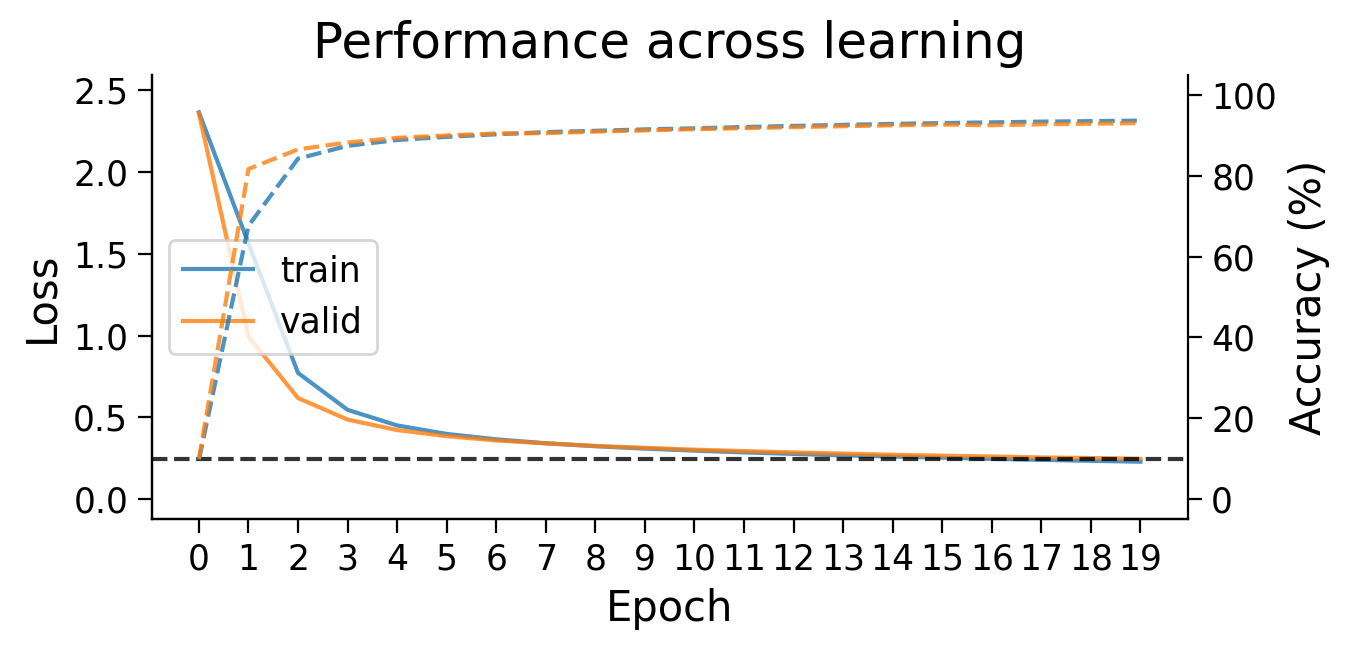

In [15]:
plot_results(MLP_results_dict);

#Final accuracy per class

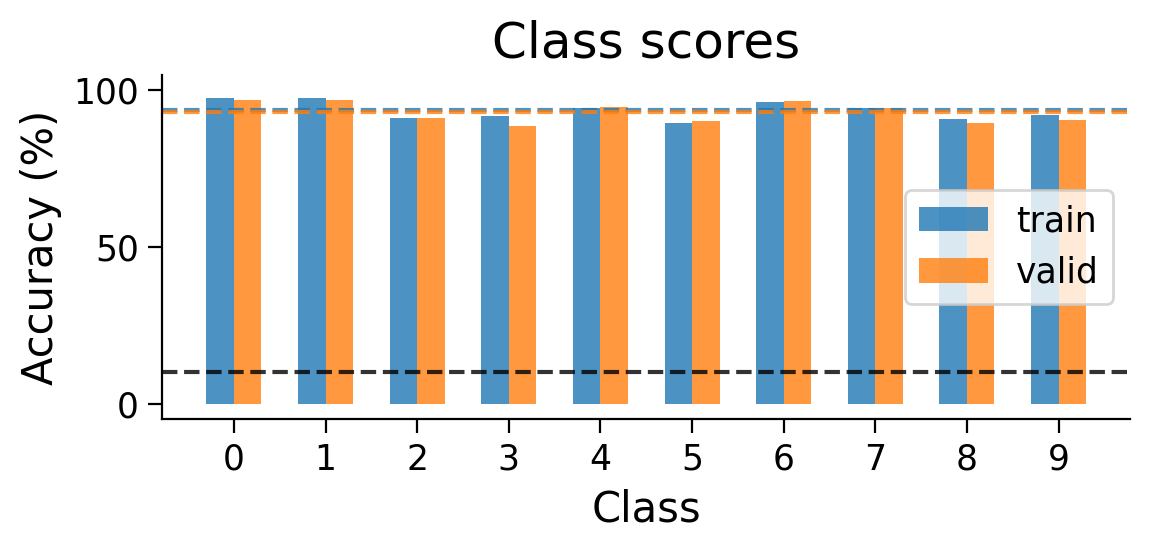

In [16]:
plot_scores_per_class(MLP_results_dict);

#Classified example images

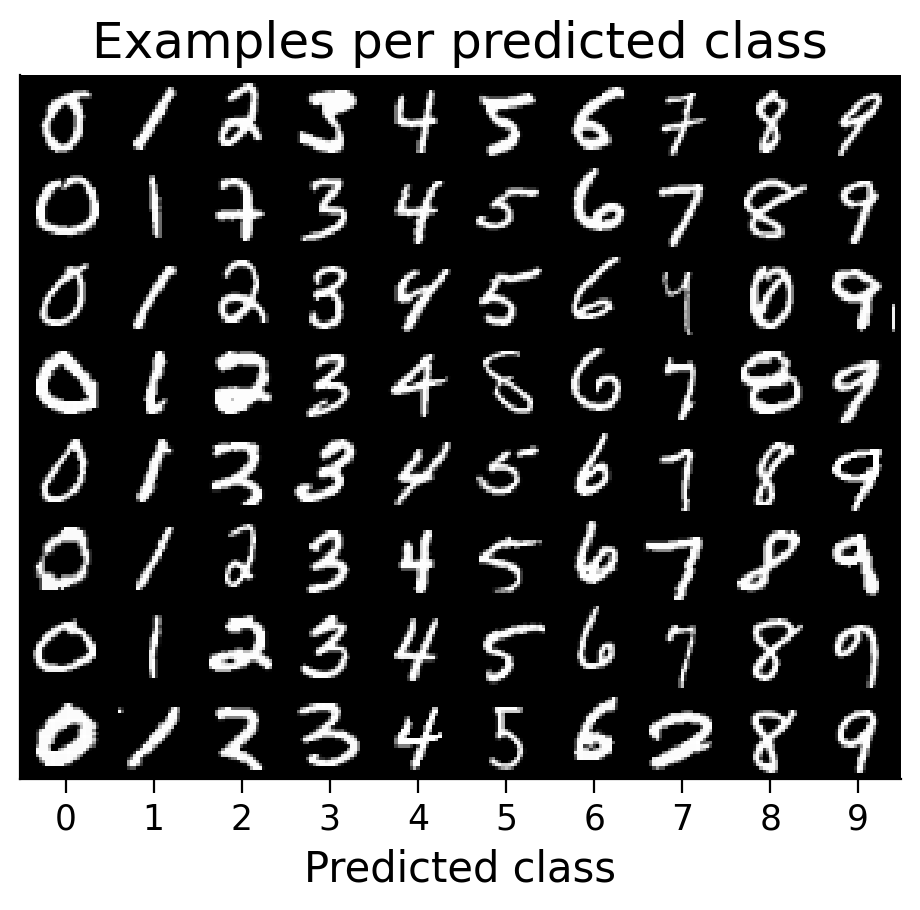

In [17]:
plot_examples(valid_loader.dataset, MLP=MLP);

#Weights before and after learning

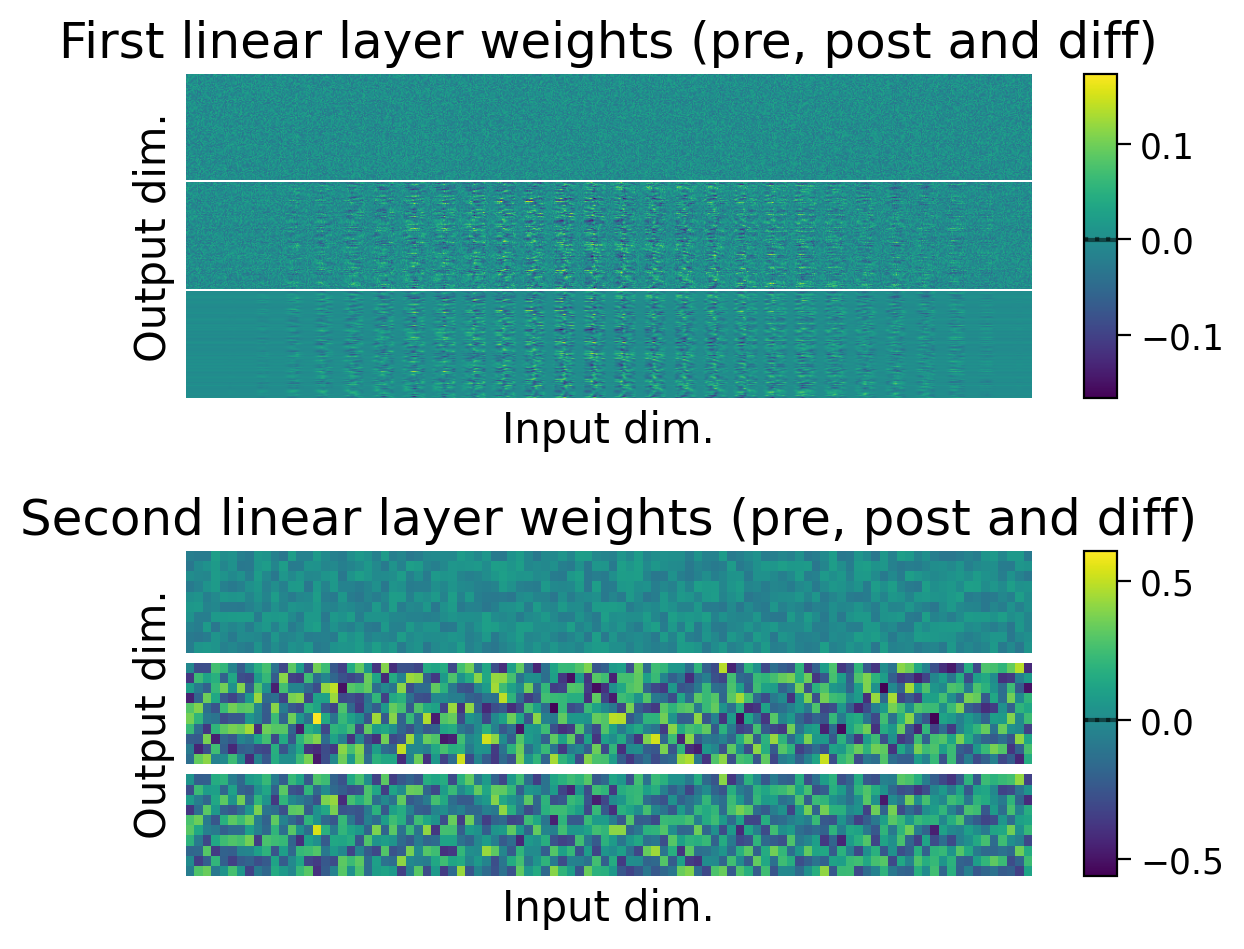

In [18]:
plot_weights(MLP=MLP);

In [19]:
# save the model after training
torch.save(MLP.state_dict(), 'model.pt')

#extract activation

In [20]:
# Dictionary to store the activations
activations = {}

# Hook function to save activations
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach().numpy()
    return hook

# Register hooks on the layers you are interested in
MLP.lin1.register_forward_hook(get_activation('lin1'))
MLP.lin2.register_forward_hook(get_activation('lin2'))

# Collect activations for each digit
digit_activations = {digit: [] for digit in range(10)}

# Iterate through the dataset to collect activations
MLP.eval()
with torch.no_grad():
    for X, y in test_loader:
        _ = MLP(X) # Forward pass to trigger hooks
        for i in range(len(y)):
            digit = y[i].item()
            digit_activations[digit].append((activations['lin1'][i], activations['lin2'][i]))

## Compute similarity matrices

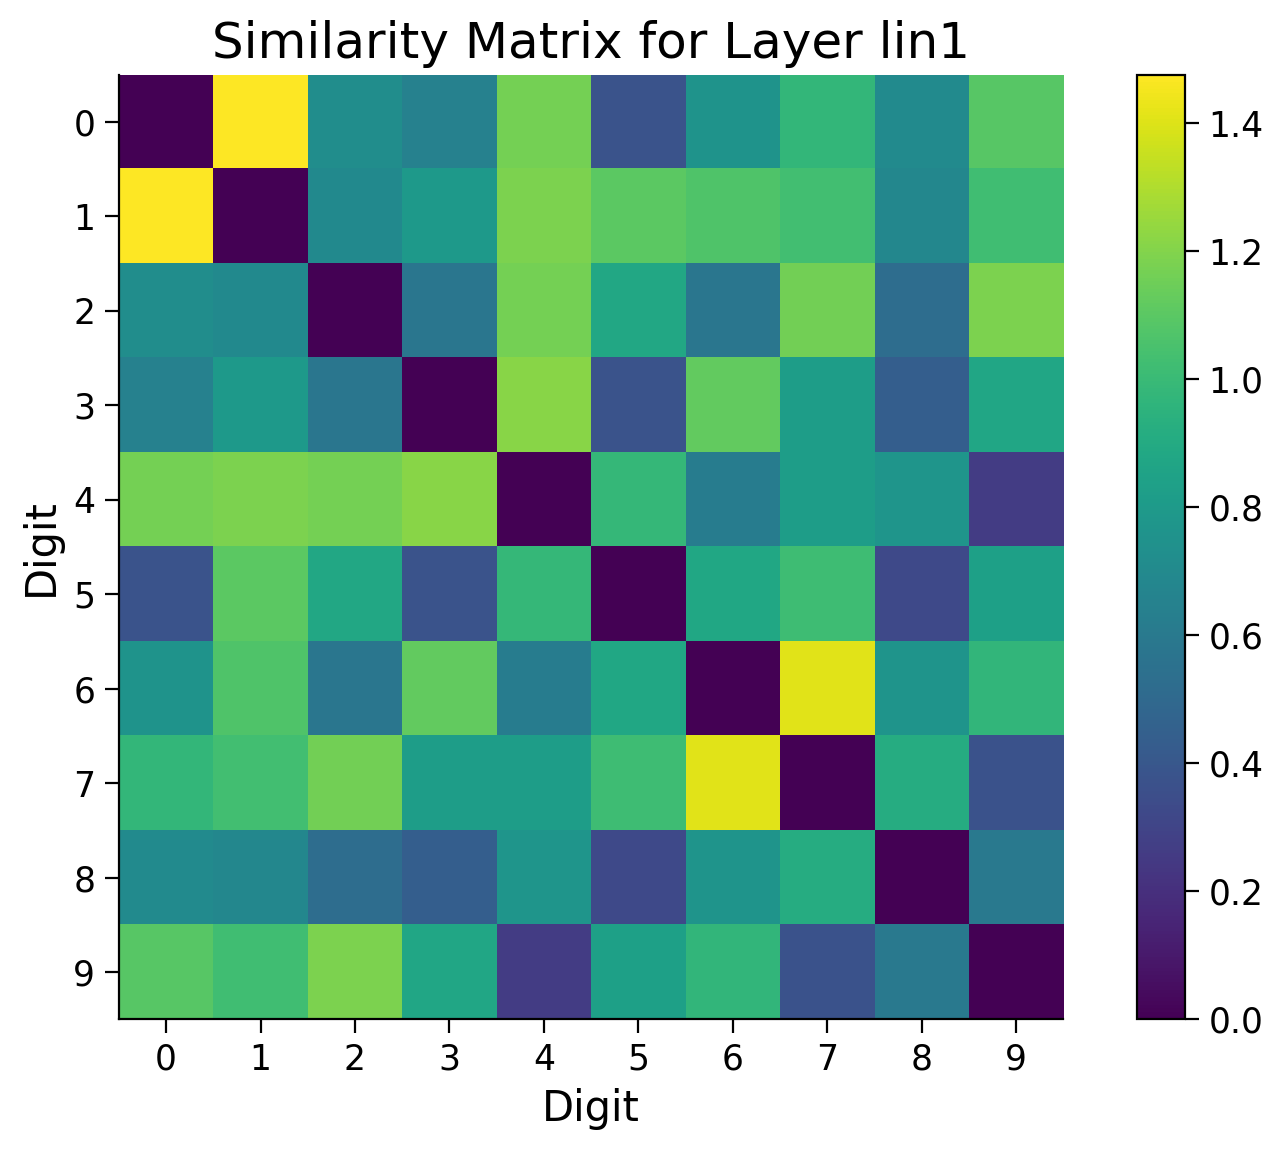

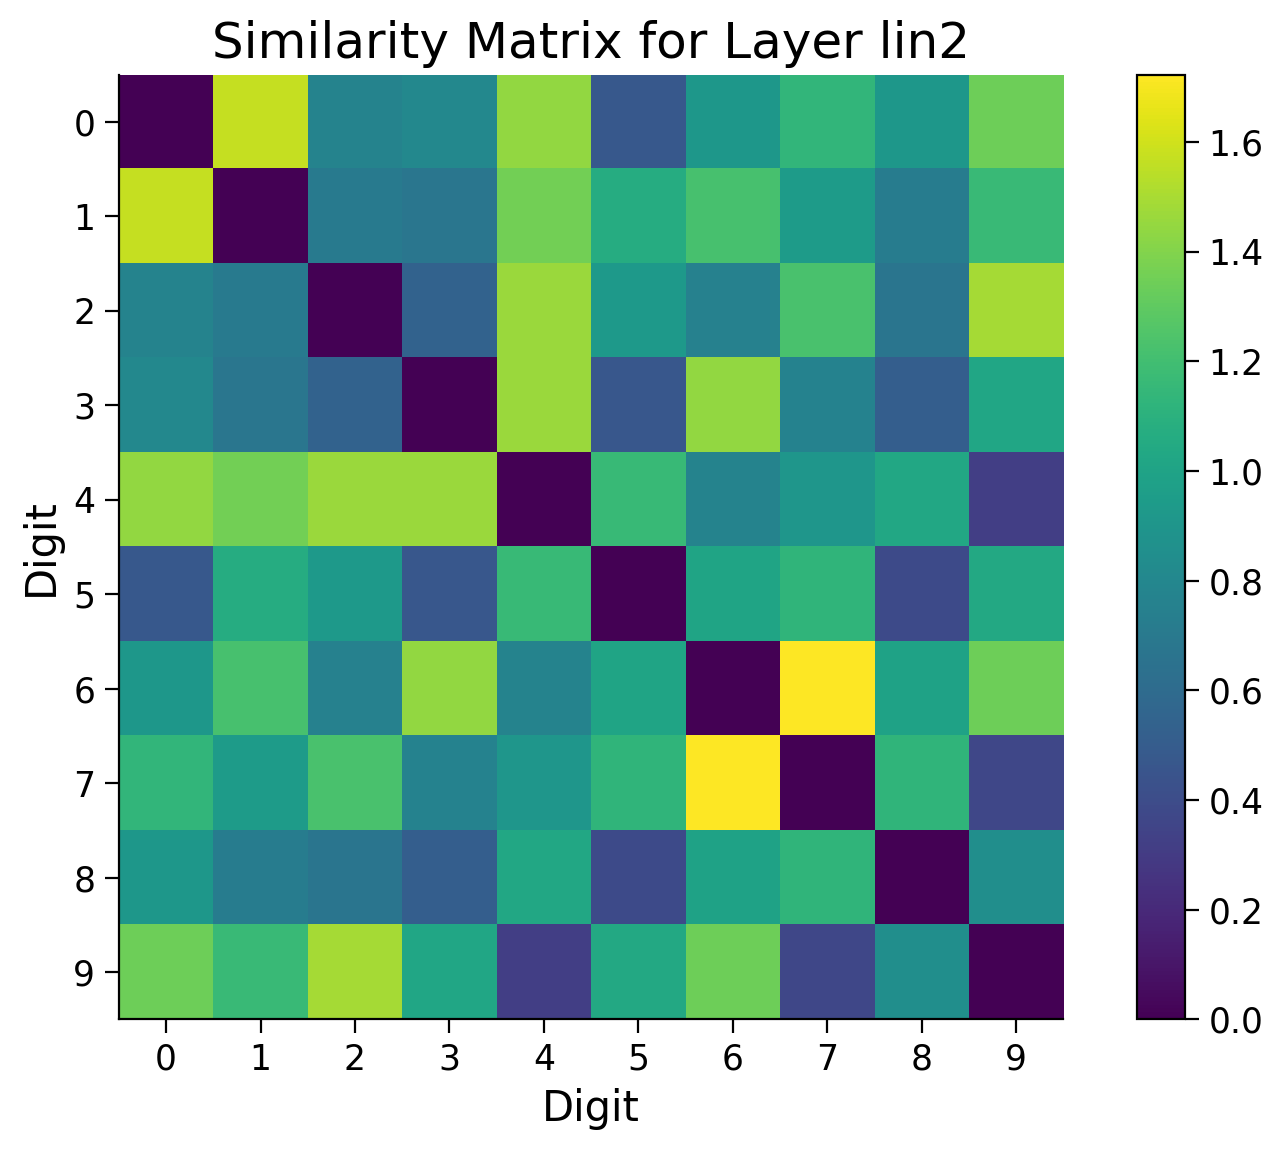

In [21]:
from scipy.spatial.distance import pdist, squareform

def compute_similarity_matrix(activations_dict):
    similarity_matrices = {}
    for layer in ['lin1', 'lin2']:  # Explicitly specify layer names
        layer_activations = []
        for digit in range(10):
            # Extract activations for the current layer and digit
            activations_for_digit = [act[0] if layer == 'lin1' else act[1] for act in activations_dict[digit]]
            # Compute mean activation for this layer and digit
            layer_activations.append(np.mean(activations_for_digit, axis=0))
        similarity_matrices[layer] = squareform(pdist(layer_activations, metric='correlation'))
    return similarity_matrices

mlp_similarity_matrices = compute_similarity_matrix(digit_activations)

# Plot similarity matrices
def plot_similarity_matrices(similarity_matrices):
    for layer, matrix in similarity_matrices.items():
        plt.figure(figsize=(8, 6))
        plt.title(f'Similarity Matrix for Layer {layer}')
        plt.imshow(matrix, cmap='viridis', interpolation='none')
        plt.colorbar()
        plt.xlabel('Digit')
        plt.ylabel('Digit')
        plt.xticks(range(10))
        plt.yticks(range(10))
        plt.show()

plot_similarity_matrices(mlp_similarity_matrices)

#Get_Layers_Activation and cosine calculate similarity-(Ming Ma's version)

In [22]:
import torch.nn as nn
from sklearn.metrics.pairwise import cosine_similarity

def hook_fn(module, input, output):
    activation[module] = output

# Use any model you define
model = MLP

# Get foward Hooks
activation = {}
for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        module.register_forward_hook(hook_fn)


In [23]:
# Get your model's parameter after training
model.load_state_dict(torch.load('model.pt', map_location=torch.device('cpu')))
model.eval()

MultiLayerPerceptron(
  (lin1): Linear(in_features=784, out_features=100, bias=False)
  (lin2): Linear(in_features=100, out_features=10, bias=False)
  (activation): Sigmoid()
  (softmax): Softmax(dim=1)
)

In [24]:
# Run test
with torch.no_grad():
    test_inputs = torch.randn(10, NUM_INPUTS)  # 确保测试输入形状正确
    output = model(test_inputs)  # 只提供测试输入X，不再提供y
    print(output)

tensor([[0.1049, 0.0276, 0.2115, 0.1976, 0.0341, 0.0509, 0.0123, 0.2099, 0.0366,
         0.1146],
        [0.0119, 0.0640, 0.0081, 0.0141, 0.0066, 0.1861, 0.0157, 0.1552, 0.1152,
         0.4230],
        [0.0049, 0.0495, 0.0551, 0.0093, 0.2413, 0.1388, 0.2998, 0.0635, 0.0824,
         0.0553],
        [0.0053, 0.0318, 0.0372, 0.0328, 0.0432, 0.6722, 0.0929, 0.0078, 0.0652,
         0.0117],
        [0.0013, 0.0146, 0.0034, 0.0809, 0.1555, 0.4073, 0.0074, 0.2154, 0.0087,
         0.1055],
        [0.0180, 0.0051, 0.0016, 0.0145, 0.2123, 0.2468, 0.0193, 0.2242, 0.0069,
         0.2513],
        [0.0007, 0.0379, 0.0491, 0.0094, 0.2200, 0.0182, 0.0190, 0.4052, 0.0079,
         0.2325],
        [0.0097, 0.2177, 0.0271, 0.4151, 0.0151, 0.1324, 0.0145, 0.1302, 0.0119,
         0.0263],
        [0.0090, 0.0390, 0.1783, 0.2336, 0.0184, 0.1056, 0.0021, 0.2662, 0.0473,
         0.1006],
        [0.0052, 0.0569, 0.5036, 0.1548, 0.0132, 0.1409, 0.0075, 0.0872, 0.0140,
         0.0166]])


In [104]:
# Calculate cosine similarity between layers
def compute_similarity(activation):
    similarities = {}
    for name, activations in activation.items():
        if activations.dim() > 2:
            activations = activations.view(activations.size(0), -1)  # Flatten
        similarity_matrix = cosine_similarity(activations)
        similarities[name] = similarity_matrix
    return similarities

similarities = compute_similarity(activation)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Similarity matrix for layer Linear(in_features=784, out_features=100, bias=False):
[[ 1.         -0.2914578  -0.15562643  0.13670065 -0.12324597  0.06329252
  -0.55916166 -0.20115177  0.05824239  0.03991045]
 [-0.2914578   1.         -0.18933271 -0.02170532  0.13543417 -0.00582529
   0.34783912  0.42161688  0.00507758 -0.09030402]
 [-0.15562643 -0.18933271  0.9999998  -0.2167484  -0.2267056  -0.30731562
   0.00643229 -0.16324309 -0.11323914 -0.02852027]
 [ 0.13670065 -0.02170532 -0.2167484   0.9999999  -0.04634322  0.15276057
  -0.1154429   0.04624529  0.25166705 -0.1960933 ]
 [-0.12324597  0.13543417 -0.2267056  -0.04634322  0.99999994  0.37667298
   0.38576752  0.2583766  -0.05800567 -0.09790839]
 [ 0.06329252 -0.00582529 -0.30731562  0.15276057  0.37667298  0.99999976
  -0.0369044   0.05649     0.19886498  0.3209236 ]
 [-0.55916166  0.34783912  0.00643229 -0.1154429   0.38576752 -0.0369044
   0.99999964  0.12961793  0.08421096 -0.22411421]
 [-0.20115177  0.42161688 -0.16324309  0.04

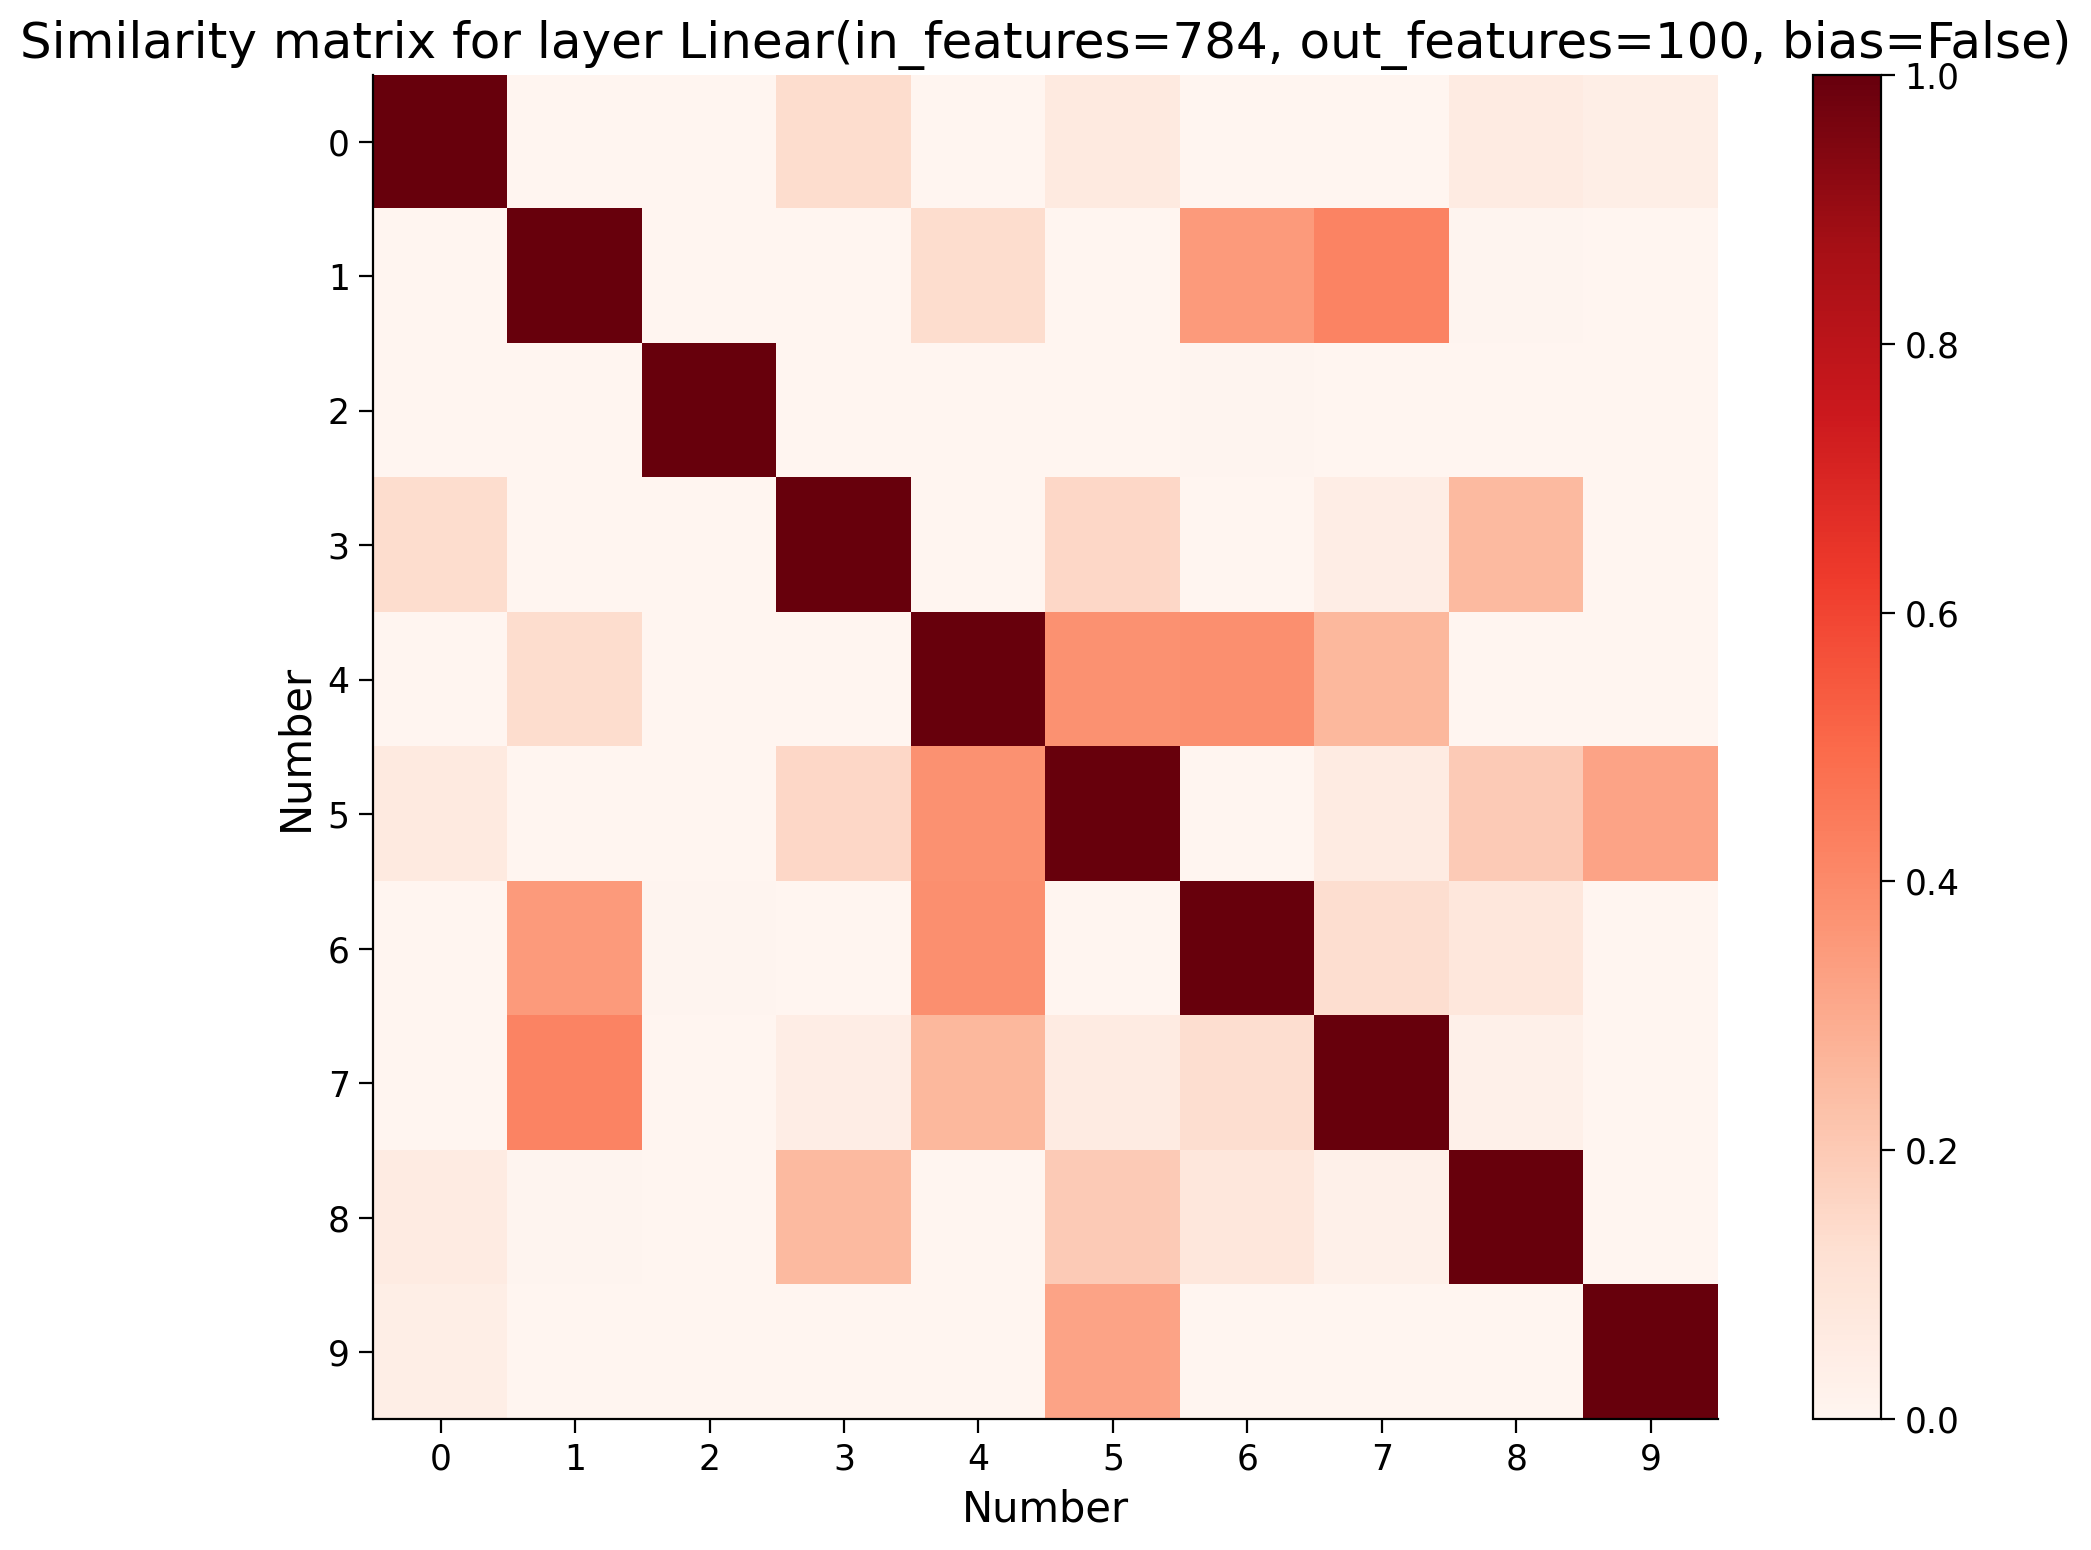

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Similarity matrix for layer Linear(in_features=100, out_features=10, bias=False):
[[ 0.99999994 -0.20228659  0.24891305  0.5887008   0.06728604  0.59675616
  -0.36564362  0.03982931  0.5035253   0.6464341 ]
 [-0.20228659  1.0000001   0.0784203   0.29596373  0.5028567   0.18201588
   0.7686704   0.8661933   0.47382134 -0.10629857]
 [ 0.24891305  0.0784203   0.99999994  0.34206456 -0.01369154  0.17733754
   0.24506006  0.00156872  0.21465173  0.43918917]
 [ 0.5887008   0.29596373  0.34206456  1.          0.36765862  0.47622156
   0.3085687   0.43793228  0.81026596  0.21778099]
 [ 0.06728604  0.5028567  -0.01369154  0.36765862  1.          0.7724441
   0.66141313  0.7106998   0.56149554  0.2957839 ]
 [ 0.59675616  0.18201588  0.17733754  0.47622156  0.7724441   1.
   0.3121803   0.43505076  0.7076428   0.7555458 ]
 [-0.36564362  0.7686704   0.24506006  0.3085687   0.66141313  0.3121803
   1.          0.6147929   0.5224548  -0.04879339]
 [ 0.03982931  0.8661933   0.00156872  0.43793228  0.

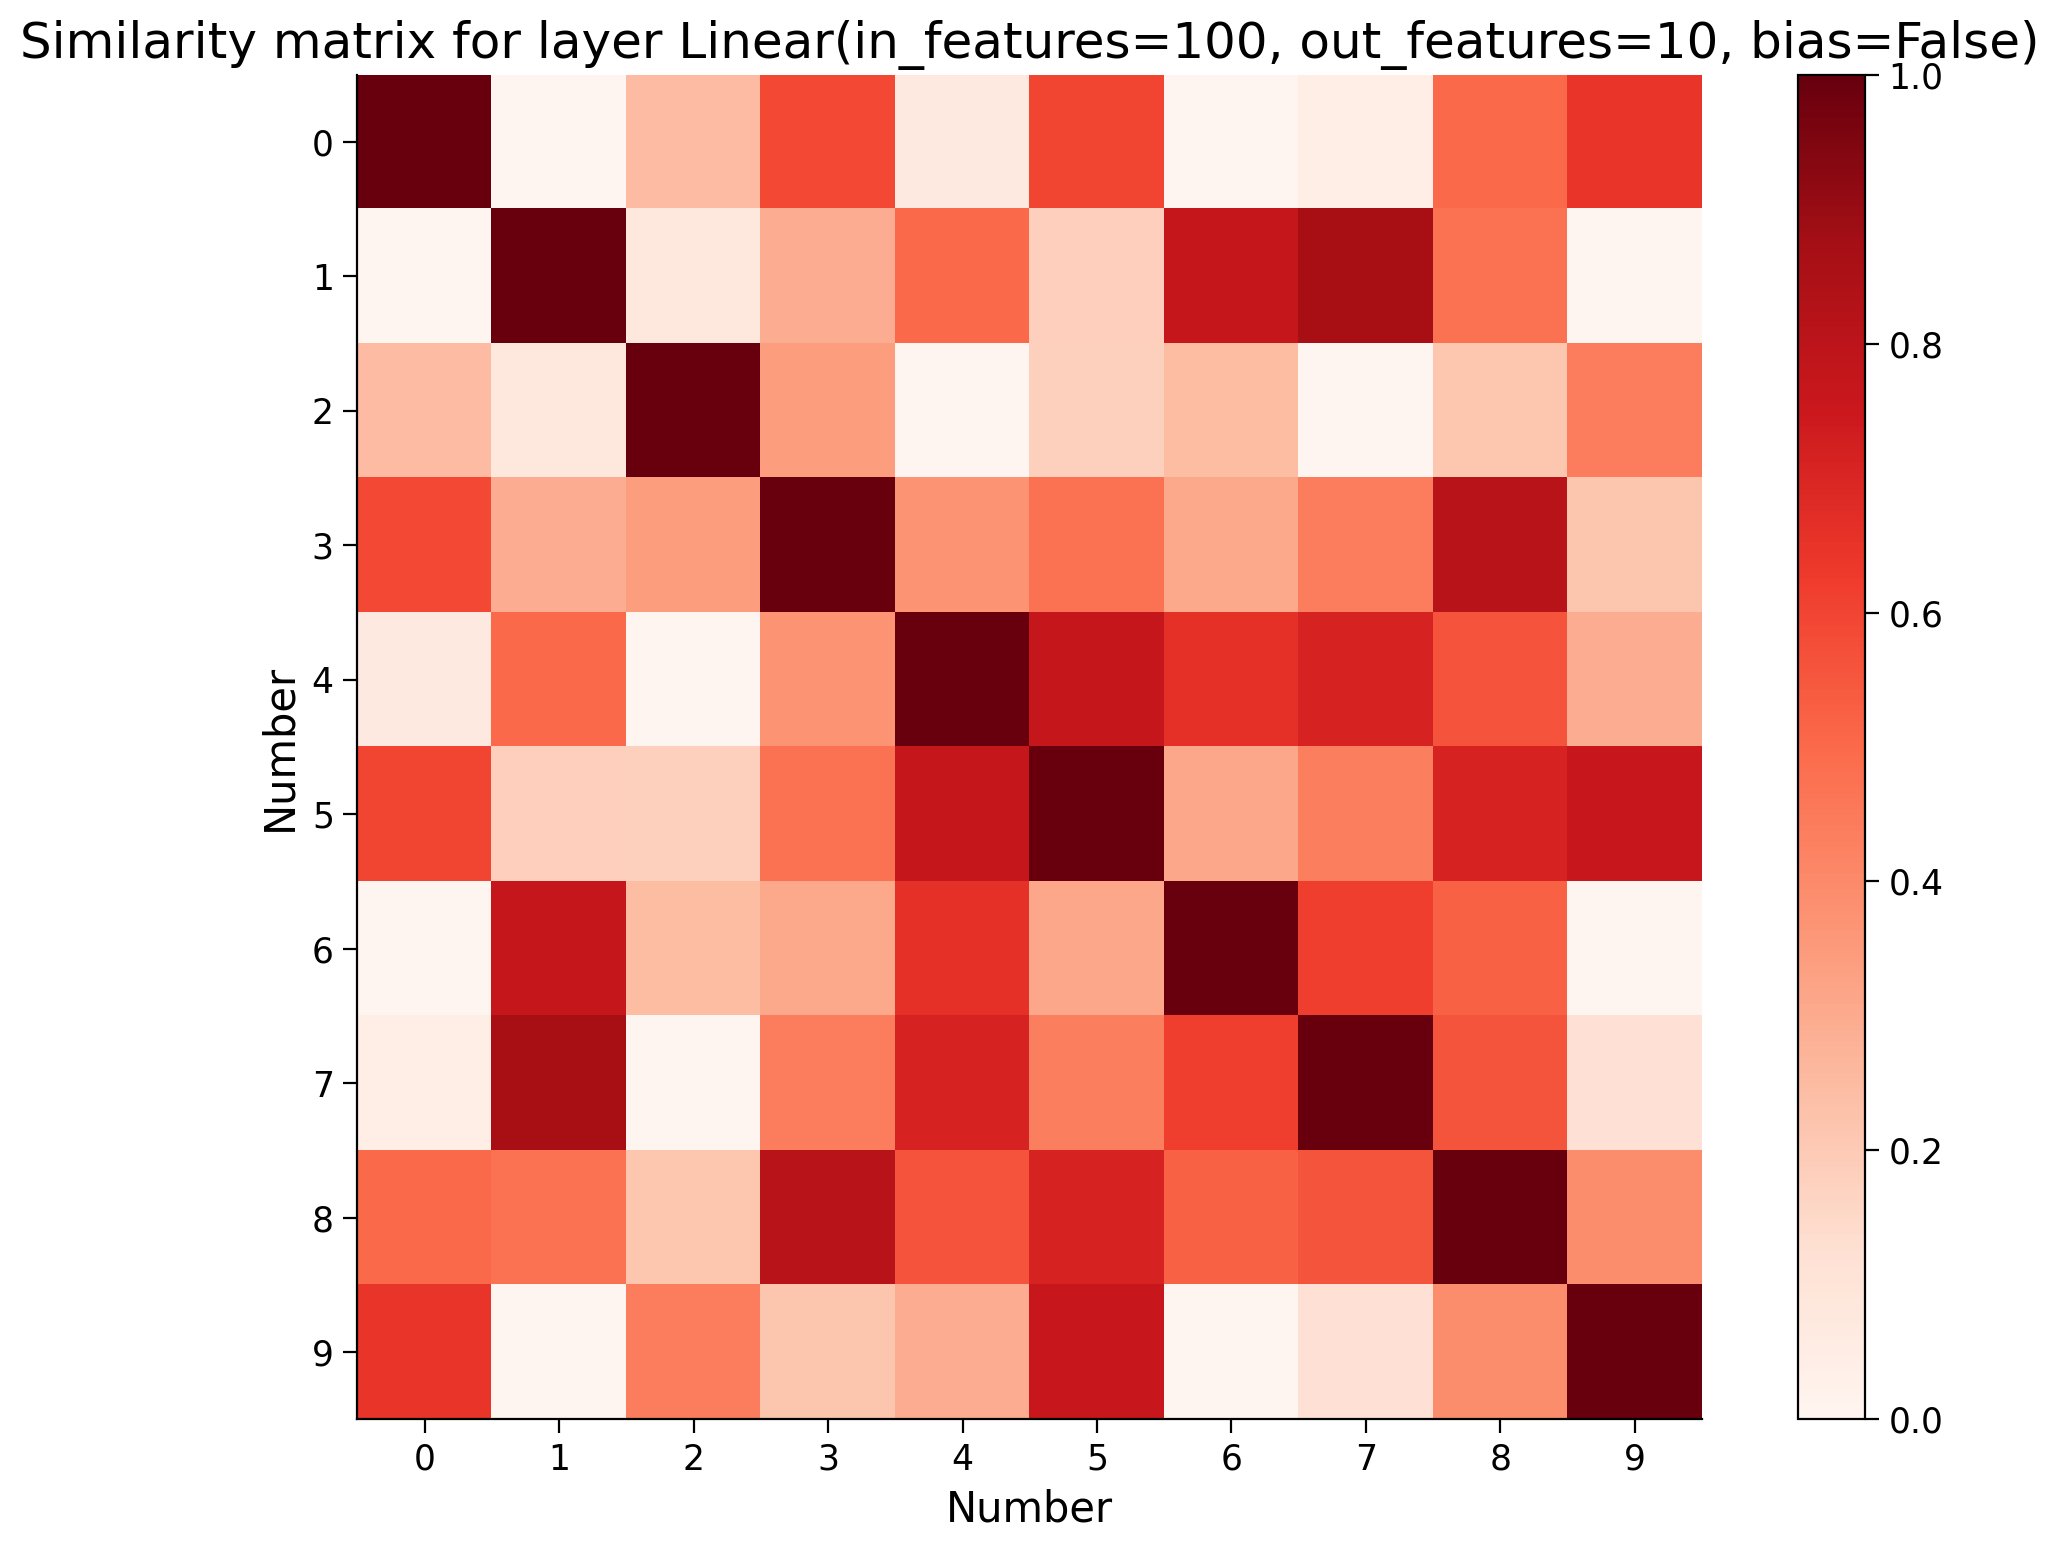

In [105]:
# Print similarity matrix and save the matrix data as csv file
import pandas as pd
from google.colab import files

for name, similarity_matrix in similarities.items():
    csv_filename = f'similarity_{name}.csv'
    df = pd.DataFrame(similarity_matrix)  # Convert to DataFrame
    df.to_csv(csv_filename, index=False, header=False)  # Save as CSV

    # Download the CSV file
    files.download(csv_filename)

    print(f'Similarity matrix for layer {name}:')
    print(similarity_matrix)
    plt.figure(figsize=(10, 8))

    tick_marks = list(range(10))
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)

    plt.xlabel('Number')
    plt.ylabel('Number')

    plt.title(f'Similarity matrix for layer {name}')
    plt.imshow(similarity_matrix, cmap='Reds', interpolation='nearest', vmin=0, vmax=1)
    plt.colorbar()
    plt.savefig(f'similarity_{name}.png')
    plt.show()
    plt.close()

In [25]:
from sklearn.metrics.pairwise import manhattan_distances

def compute_laplacian_kernel(activation, sigma=1.0):
    similarities = {}
    for name, activations in activation.items():
        if activations.dim() > 2:
            activations = activations.view(activations.size(0), -1)  # Flatten
        # Compute Manhattan distances
        manhattan_dists = manhattan_distances(activations)
        # Compute Laplacian kernel
        similarity_matrix = np.exp(-manhattan_dists / sigma)
        similarities[name] = similarity_matrix
    return similarities

similarities = compute_laplacian_kernel(activation)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Similarity matrix for layer Linear(in_features=784, out_features=100, bias=False):
[[1.00000000e+00 1.34156204e-46 4.71613432e-43 1.32421828e-46
  1.25940785e-50 1.10522736e-48 1.22922617e-46 1.23124667e-38
  3.45167226e-33 1.34892572e-37]
 [1.34156204e-46 1.00000000e+00 8.99245917e-41 3.10744849e-45
  3.66527851e-49 3.04858837e-48 5.95802064e-49 7.61857168e-44
  2.16794416e-42 3.98648194e-49]
 [4.71613432e-43 8.99245917e-41 1.00000000e+00 6.85151142e-32
  9.93716874e-42 3.55682088e-41 7.29114986e-37 2.70553329e-44
  8.38501609e-45 1.75270224e-43]
 [1.32421828e-46 3.10744849e-45 6.85151142e-32 1.00000000e+00
  7.09870685e-46 6.35299046e-49 1.61513227e-49 3.43592106e-40
  1.26709204e-45 2.00328678e-38]
 [1.25940785e-50 3.66527851e-49 9.93716874e-42 7.09870685e-46
  1.00000000e+00 7.17988895e-37 3.43218480e-40 3.03390227e-44
  1.25733756e-46 6.53626159e-47]
 [1.10522736e-48 3.04858837e-48 3.55682088e-41 6.35299046e-49
  7.17988895e-37 1.00000000e+00 2.07757662e-46 1.18851890e-48
  1.0403

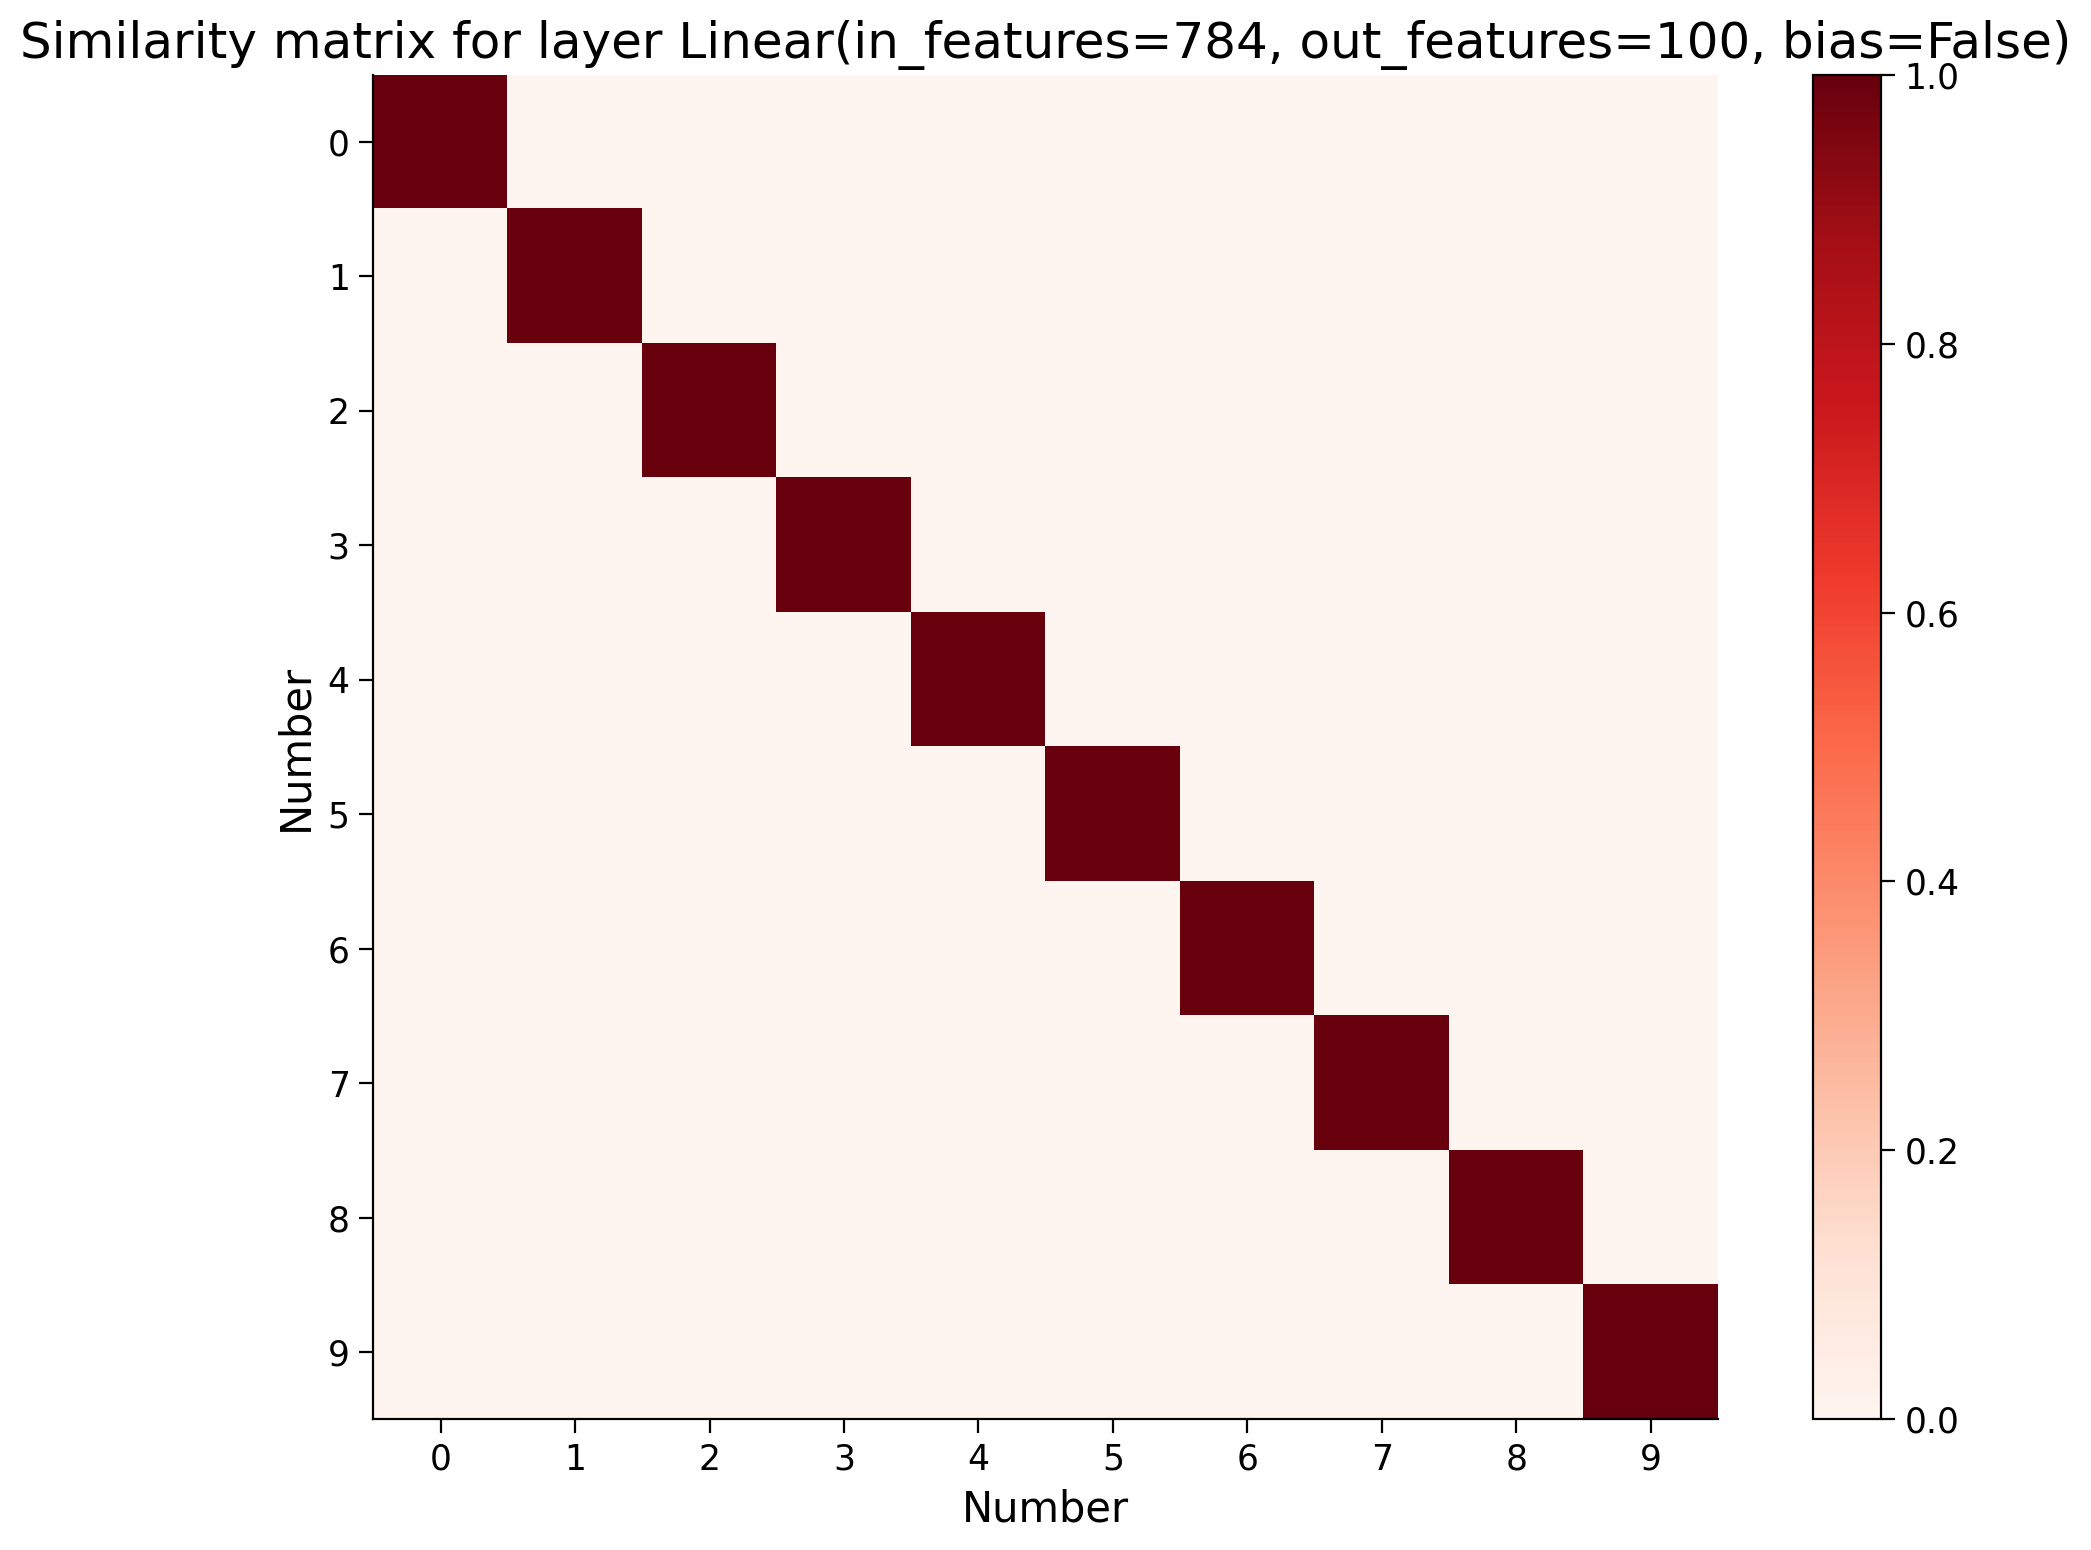

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Similarity matrix for layer Linear(in_features=100, out_features=10, bias=False):
[[1.00000000e+00 2.29660855e-07 4.38424598e-08 2.14105910e-08
  3.36927077e-07 2.94115587e-08 1.02813632e-07 1.23441526e-05
  5.08384051e-04 6.81412541e-05]
 [2.29660855e-07 1.00000000e+00 3.33068133e-07 1.16421379e-07
  4.06501271e-07 3.08537841e-06 2.26429187e-07 3.59292988e-06
  1.29892298e-06 4.50804573e-07]
 [4.38424598e-08 3.33068133e-07 1.00000000e+00 7.90773627e-05
  1.14777380e-07 3.73442471e-08 1.92897373e-06 1.34661067e-07
  1.58272830e-07 1.07568788e-07]
 [2.14105910e-08 1.16421379e-07 7.90773627e-05 1.00000000e+00
  3.63160014e-08 2.36858678e-09 3.01426645e-09 2.39309015e-07
  7.72929906e-08 6.12309387e-07]
 [3.36927077e-07 4.06501271e-07 1.14777380e-07 3.63160014e-08
  1.00000000e+00 9.66852820e-05 4.83478882e-06 7.15609745e-07
  6.51809078e-07 2.61502905e-07]
 [2.94115587e-08 3.08537841e-06 3.73442471e-08 2.36858678e-09
  9.66852820e-05 1.00000000e+00 2.98221065e-06 1.63228322e-08
  4.38307

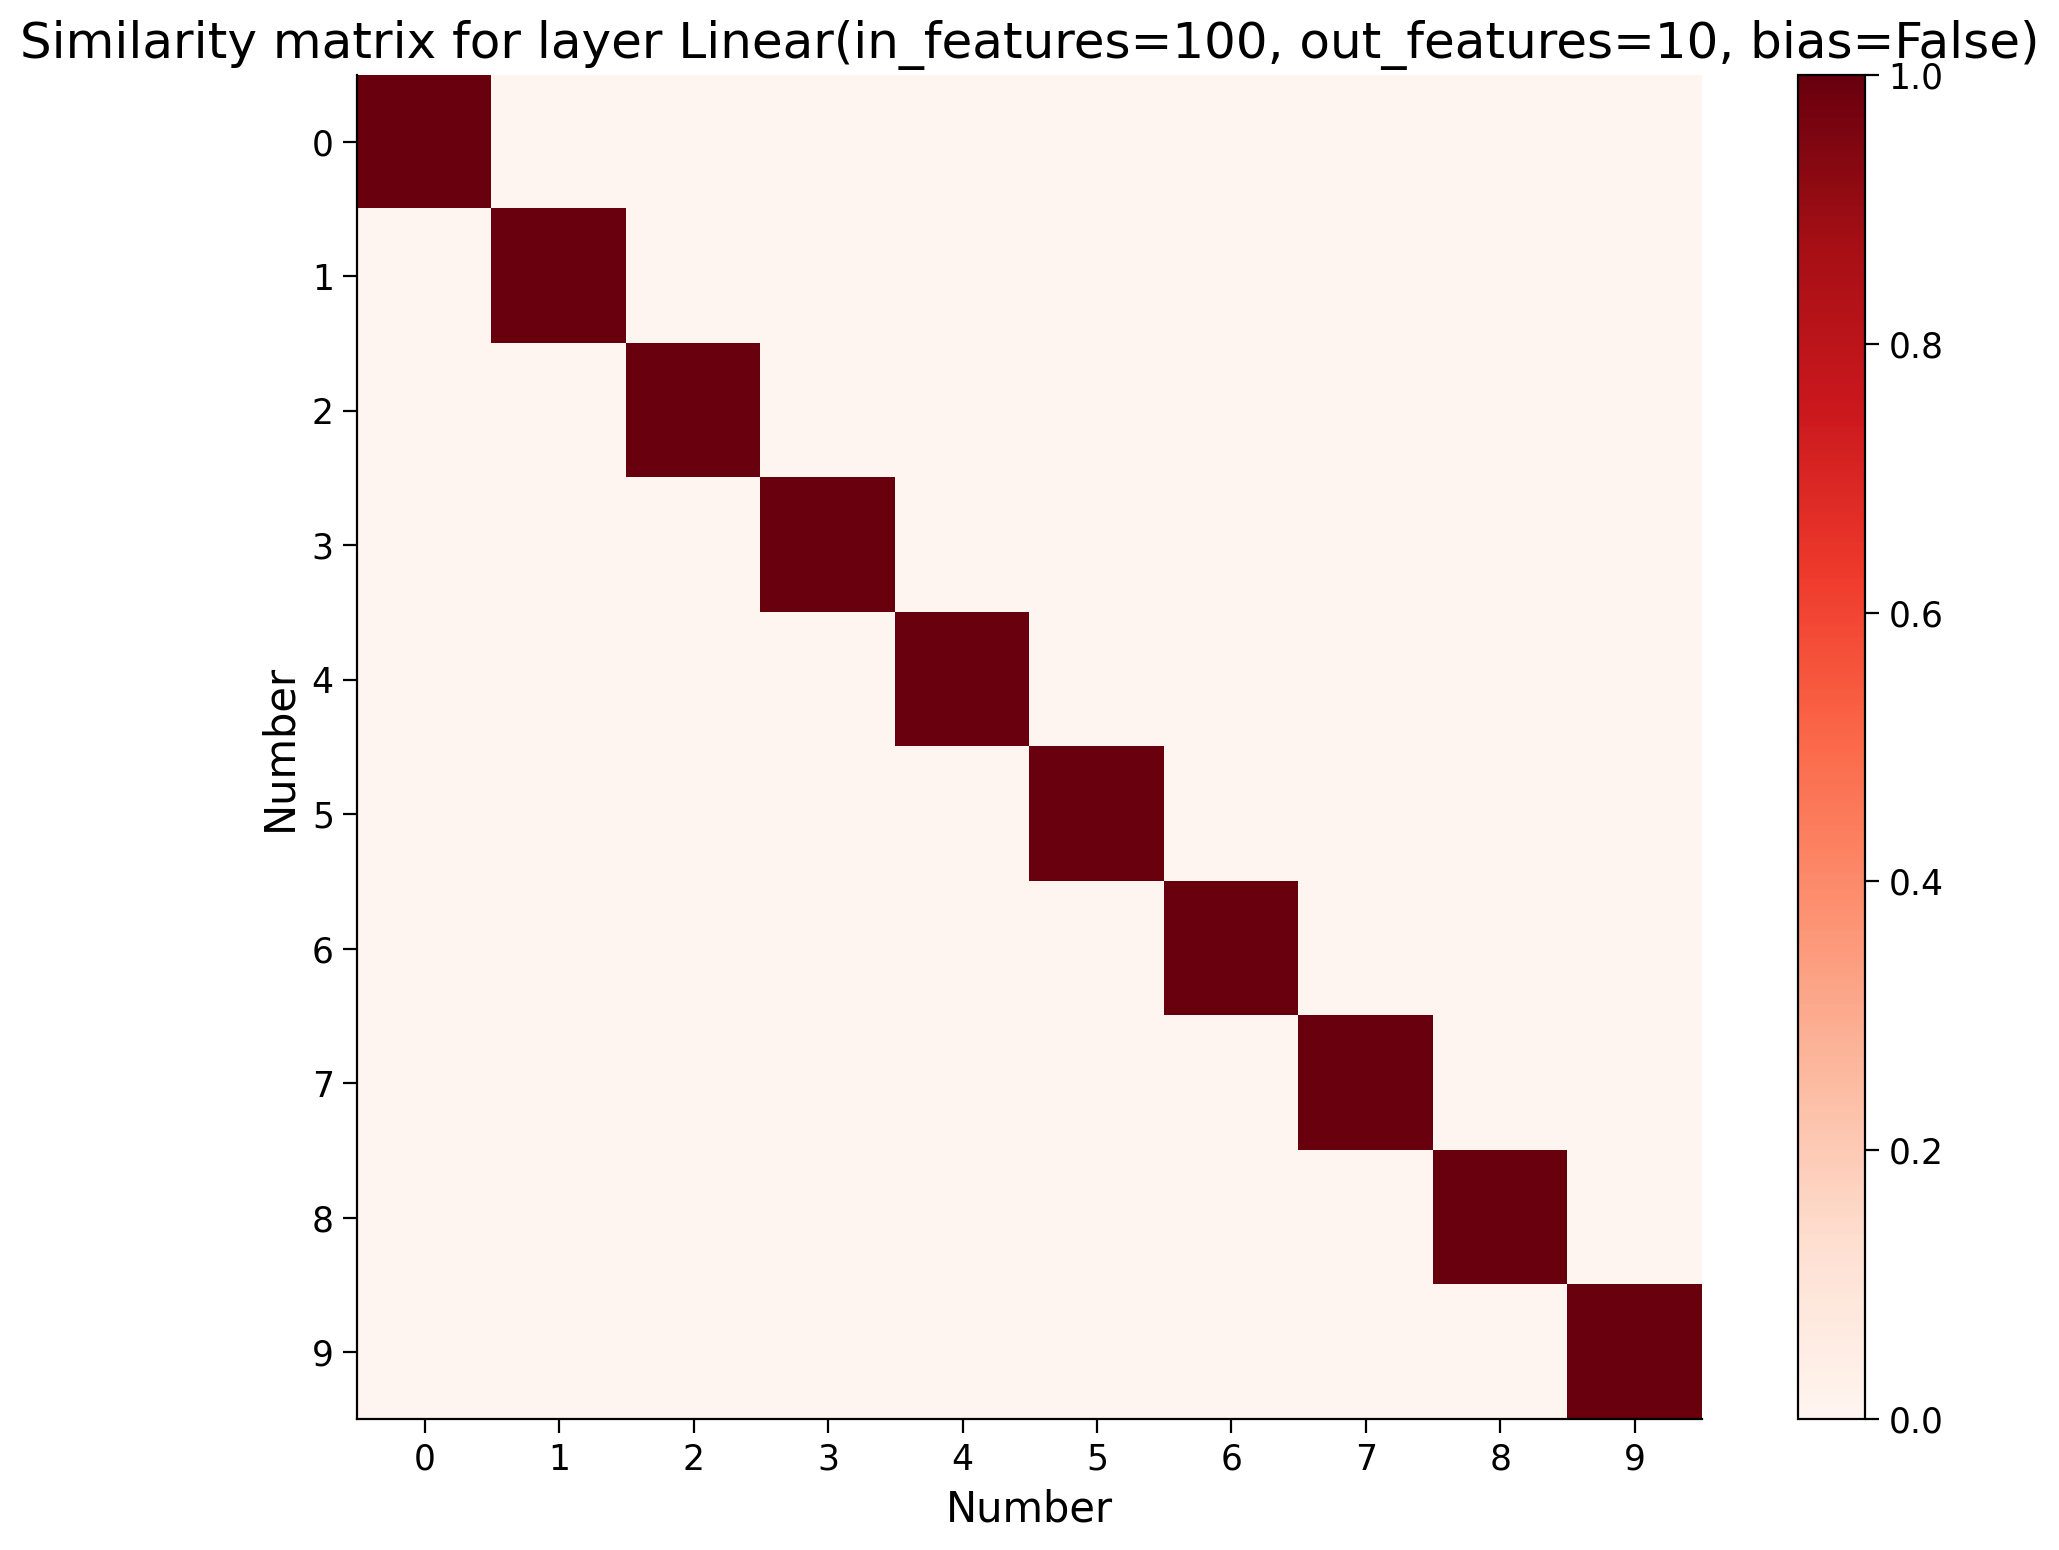

In [26]:
# Print similarity matrix and save the matrix data as csv file
import pandas as pd
from google.colab import files

for name, similarity_matrix in similarities.items():
    csv_filename = f'similarity_{name}.csv'
    df = pd.DataFrame(similarity_matrix)  # Convert to DataFrame
    df.to_csv(csv_filename, index=False, header=False)  # Save as CSV

    # Download the CSV file
    files.download(csv_filename)

    print(f'Similarity matrix for layer {name}:')
    print(similarity_matrix)
    plt.figure(figsize=(10, 8))

    tick_marks = list(range(10))
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)

    plt.xlabel('Number')
    plt.ylabel('Number')

    plt.title(f'Similarity matrix for layer {name}')
    plt.imshow(similarity_matrix, cmap='Reds', interpolation='nearest', vmin=0, vmax=1)
    plt.colorbar()
    plt.savefig(f'similarity_{name}.png')
    plt.show()
    plt.close()